In [2]:
import sys
sys.path.append('/Users/jchen/insitro/posh_internal/common_utils') ## Adding path to common utils
sys.path.append('/Users/jchen/insitro/posh_internal/core')
sys.path.append('/Users/jchen/insitro/core')

%load_ext autoreload
%autoreload 2

In [3]:
import math
import numpy as np
from matplotlib import pyplot as plt
from insitro_core.pyxcell.utils import data, plate, microscope
from scipy.interpolate import interp1d
import matplotlib.patches as patches

import cv2 as cv
from scipy.spatial import KDTree
from scipy.interpolate import griddata

import imreg_dft as ird

import os
from datetime import date 
import pandas as pd
from PIL import Image, ImageOps
from insitro_core.pyxcell.type_definitions import (
    CanonicalPlateAcquisition,
    CanonicalPlateDataFrameSchema
)
from skimage import registration, transform, img_as_uint
from insitro_core.pyxcell.modules.registration.plate_geometry import _get_inverse_camera_rotation_transform

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x116f89f40>> (for pre_run_cell):


TypeError: pre_run_cell() takes 1 positional argument but 2 were given

ModuleNotFoundError: No module named 'redun'

In [2]:
#argolight_measurement_id = 'c4a21515-c302-4dfe-bd7c-42c01884bb50' #Nikon1_pyxscope N
#argolight_measurement_id = 'ba122adc-79bc-4f4f-8f7c-f29212850495' #Charmander W 
#argolight_measurement_id = 'b00e87c2-fdd3-4480-8e8d-2f7b38566e45'#Squirtle N
argolight_measurement_id = '1bca6e1c-286b-4109-9732-891f3bed4d3a'#Squirtle 8/31/23

df = data.create_acquisition_dataframe(argolight_measurement_id) 
df = plate.standardize_column_mappings(df, microscope.SourceMicroscope.NIKON_3_CANONICAL)

In [3]:
def check_argolight(df):
    assert df['plate_id'].unique()[0] == 'AR001', f"Not an Argolight plate. Orientation computation uses on Argolight plate"

In [4]:
check_argolight(df)
well_id = 'A01'
fovs = [0]
paths = []
loc_x = []
loc_y = []
physical_size_x = df['physical_size_x'].unique()[0]
physical_size_y = df['physical_size_x'].unique()[0]

for fov in fovs:
    paths.append(df[(df['field_id'] == fov) & (df['well_loc']== well_id)]['path'].unique()[0])
    loc_x.append(df[(df['field_id'] == fov) & (df['well_loc']== well_id)]['position_x'].unique()[0])
    loc_y.append(df[(df['field_id'] == fov) & (df['well_loc']== well_id)]['position_y'].unique()[0])
    
#translation_gt_x = (loc_x[1] - loc_x[0])/physical_size_x #In Pixels
#translation_gt_y = (loc_y[1] - loc_y[0])/physical_size_y #In Pixels


In [5]:
images = []
for path in paths:
    images.append(data.read_image(path, data.ImageStorageFormat.CHW))

In [6]:
img = images[0][0]

In [9]:
# Conver image to 8 bit image.
img_8bit = cv.cvtColor((img/256).astype('uint8'), cv.COLOR_GRAY2BGR)

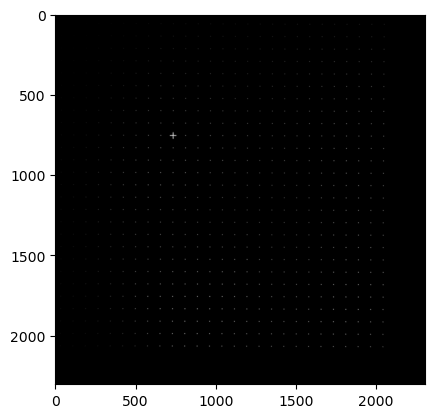

In [10]:
plt.imshow(img_8bit)

In [11]:
#Function to detect and capture the dots/rings location


def detect_and_capture_dots(image):
    # Convert the image to grayscale if it's not already
    if len(image.shape) == 3:
        gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    else:
        gray_image = image
    # Conver the image to binary
    _, binary_image = cv.threshold(gray_image, 1, 255, cv.THRESH_BINARY)
    # Find contours of dots
    contours, _ = cv.findContours(binary_image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    dot_positions = []
    # Iterate through the detected contours and find the center of each dot
    for contour in contours:
        M = cv.moments(contour)
        if M["m00"] > 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            dot_positions.append((cX, cY))
    return dot_positions



In [12]:
dot_positions = detect_and_capture_dots(img_8bit)

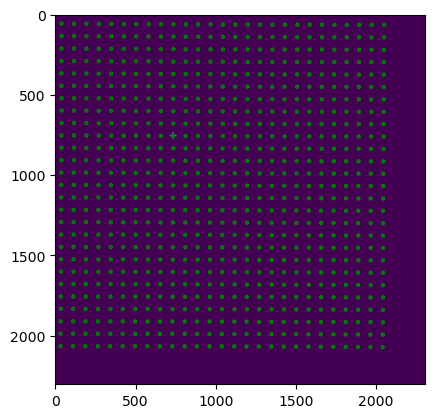

In [26]:
#Optional: Visualized dot position the function capture and make sure capture all dots.

# Load numpy image
image = images[0][0]
fig, ax = plt.subplots(1)
ax.imshow(image)

# Iterate through the dot_positon and draw circle around each dot. 
for (x, y) in dot_positions:
    roi = image[y, x]

    rect = patches.Circle((x, y, 5), linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(rect)

plt.show()

In [16]:
#Function to measure the intensity of dots
def measure_intensity_of_dots(image, dot_positions):
    intensity_values = []
    for (x, y) in dot_positions:
        intensity = int(image[y, x][0])
        intensity_values.append(intensity)
    return intensity_values

In [17]:
intensity_values = measure_intensity_of_dots(img_8bit, dot_positions)

In [21]:
#Interpolate linearly the intensity value of the blanks between the dots/rings 


def interpolate_intensity_2d(dot_positions, intensity_values, image_shape):

    dot_x_coordinates = [pos[0] for pos in dot_positions]
    dot_y_coordinates = [pos[1] for pos in dot_positions]
    # Create a grid of x and y coordinates
    x_range = np.arange(0, image_shape[1], 1)
    y_range = np.arange(0, image_shape[0], 1)
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    # Perform 2D interpolation using griddata
    interpolated_intensity = griddata((dot_x_coordinates, dot_y_coordinates), intensity_values, (grid_x, grid_y), method='nearest')
    return interpolated_intensity


In [22]:
interpolate_intensity = interpolate_intensity_2d(dot_positions, intensity_values, img_8bit.shape)

In [24]:
# Optional: to visualize the heatmap of interpolate_intensity.
def plot_heatmap(image_shape, interpolated_intensity_2d):
    x_range = np.arange(0, image_shape[1], 1)
    y_range = np.arange(0, image_shape[0], 1)
    # Reshape the interpolated_intensity array to match the image size
    interpolated_intensity_2d = interpolated_intensity_2d.reshape(len(y_range), len(x_range))
    plt.figure(figsize=(8, 6))
    plt.imshow(interpolated_intensity_2d, cmap='viridis', extent=[min(x_range), max(x_range), min(y_range), max(y_range)])
    plt.colorbar(label='Intensity')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title('Intensity Heatmap')
    plt.show()


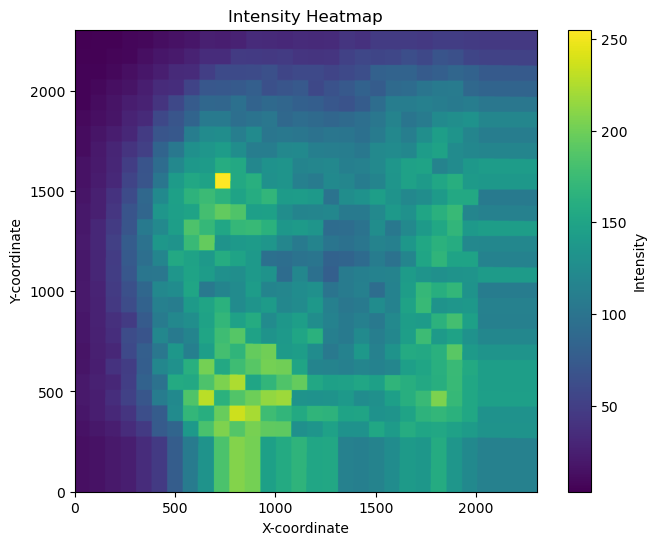

In [25]:
plot_heatmap(img_8bit.shape, interpolate_intensity)